# PINN

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

## Create the PINN class:

In [2]:
class PINN(tf.keras.models.Model):
    def __init__(self,
                num_layers: int,
                num_nodes: list,
                input_shape: tuple,
                output_shape: int,
                optimizer: tf.keras.optimizers,
                loss_weights: list):

        super(PINN, self).__init__()

        self.x = 0
        self.target = 0

        self.nn = tf.keras.Sequential()
        self.nn.add(tf.keras.layers.Dense(num_nodes[0], input_shape= input_shape, activation= tf.nn.relu,
        kernel_initializer= tf.initializers.glorot_normal,
        bias_initializer= tf.initializers.glorot_normal))

        # Add layers to network
        for layer in range(1, num_layers):
            self.nn.add(tf.keras.layers.Dense(num_nodes[layer], activation= tf.nn.tanh))

        # Add last layer:
        self.nn.add(tf.keras.layers.Dense(output_shape))

        self.nn.compile(optimizer= optimizer, loss= self.custom_loss, loss_weights= loss_weights)
    
    # Create custom loss function:
    def custom_loss(self, y_true, y_pred):

        x, x_type = self.x
        x = tf.reshape(x, (len(x), 1))
        x_type = tf.reshape(x_type, (len(x), 1))

        # Make sure everything is in the right dimension:
        y_pred, dy_pred, ddy_pred = self.get_gradients(x)
        y_pred = tf.reshape(y_pred, (len(y_pred), 1))
        dy_pred = tf.reshape(dy_pred, (len(dy_pred), 1))
        ddy_pred = tf.reshape(ddy_pred, (len(ddy_pred), 1))

        y_true = tf.reshape(tf.cast(y_true, tf.float64), (len(y_true), 1))

        # Calculate the loss inside the domain:
        inside = tf.reduce_mean(tf.abs(tf.add(y_pred, ddy_pred)), axis= 1)
        #inside = tf.multiply(inside, tf.subtract(np.ones((len(x_type), 1)), x_type))

        # Calculate the loss on the boundary:
        boundary = tf.abs(tf.subtract(tf.multiply(y_pred, x_type), tf.multiply(self.target, x_type)))
        boundary = tf.reduce_mean(boundary)

        return tf.add(tf.multiply(inside, 1), tf.multiply(boundary, 120))

    # Function for calculating the gradients:
    def get_gradients(self, x):
        with tf.GradientTape(persistent= True) as g:
            g.watch(x)

            with tf.GradientTape(persistent= True) as gg:
                gg.watch(x)
                
                y_pred = tf.cast(self.nn(x), tf.float64)
            
        dy_pred = g.gradient(y_pred, x)
        ddy_pred = gg.gradient(y_pred, x)

        return y_pred, dy_pred, ddy_pred
    
    # Provide the data to the PINN:
    def provide_data(self, x, target):
        self.x = x
        self.target = target

## Custom loss function:

In [3]:
# Parameters:
num_layers = 4
num_nodes = [100, 100, 100, 100]
input_shape = (1,)
learning_rate = 0.0001
output_shape = 1
loss_weights = [1, 1]

#activation = [tf.nn.tanh, tf.nn.tanh, tf.nn.relu, tf.nn.relu]
optimizer = tf.keras.optimizers.SGD(learning_rate= learning_rate)

# Create model:
model = PINN(num_nodes= num_nodes, 
             num_layers= num_layers, 
             input_shape= input_shape, 
             output_shape= output_shape,
             loss_weights= loss_weights,
             optimizer= optimizer)

print(model.nn.summary())

2021-11-26 14:47:16.196182: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-26 14:47:16.200416: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-11-26 14:47:16.201737: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               200       
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 101       
Total params: 30,601
Trainable params: 30,601
Non-trainable params: 0
_________________________________________________________________
None


In [4]:
# Data parameters:
num_samples = 100
min_sample = 0
max_sample = np.pi/2
num_boundray = 2
boundrays = [0, np.pi/2]

# True function to be calculated:
func = lambda x: np.sin(x)

# Generate data:
x_train = np.random.uniform(low= min_sample, high= max_sample, size= (num_samples - num_boundray, 1))
x_train = np.append(x_train, np.array([boundrays[0], boundrays[1]]))
x_train = tf.convert_to_tensor(tf.reshape(x_train, shape= (len(x_train), 1)))

x_type = np.concatenate([np.zeros(num_samples - num_boundray), np.ones(num_boundray)])
x_type = tf.convert_to_tensor(x_type, dtype=  tf.float64, )
x_type = tf.reshape(x_type, shape= (len(x_type), 1))

x = [x_train, x_type]

# Generate target:
target = func(x_train)

# Give data to model:
model.provide_data(x, target)

In [5]:
model.nn.fit(x_train, target, epochs= 1000, batch_size= 1)

2021-11-26 14:47:17.016700: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/1000


2021-11-26 14:47:17.513231: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


100/100 [==============================] - 2s 11ms/step - loss: 1.2348
Epoch 2/1000
100/100 [==============================] - 1s 12ms/step - loss: 1.1870
Epoch 3/1000
100/100 [==============================] - 1s 11ms/step - loss: 1.1843
Epoch 4/1000
100/100 [==============================] - 1s 11ms/step - loss: 1.1836
Epoch 5/1000
100/100 [==============================] - 1s 11ms/step - loss: 1.1820
Epoch 6/1000
100/100 [==============================] - 2s 22ms/step - loss: 1.1801
Epoch 7/1000
100/100 [==============================] - 2s 15ms/step - loss: 1.1785
Epoch 8/1000
100/100 [==============================] - 1s 11ms/step - loss: 1.1768
Epoch 9/1000
100/100 [==============================] - 1s 11ms/step - loss: 1.1769
Epoch 10/1000
100/100 [==============================] - 1s 12ms/step - loss: 1.1763
Epoch 11/1000
 59/100 [================>.............] - ETA: 0s - loss: 1.1770

KeyboardInterrupt: 

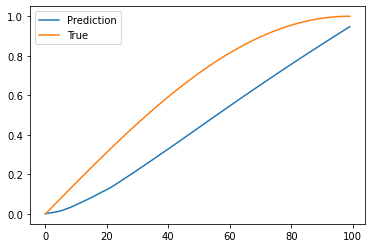

In [ ]:
x_pred = tf.convert_to_tensor(np.linspace(start= min_sample, stop= max_sample, num= num_samples))

prediction = model.nn.predict(x_pred)
true = func(x_pred)

plt.figure()
plt.plot(prediction)
plt.plot(true)
plt.legend(["Prediction", "True"])


tf.Tensor(
[[0.        ]
 [1.57079633]], shape=(2, 1), dtype=float64)
tf.Tensor(
[[1.]
 [1.]], shape=(2, 1), dtype=float64)
[[0.]
 [1.]]
